In [1]:
import numpy as np
from pandas import DataFrame

In [10]:
import os
import pandas as pd

metric_dir = '/home/keisuke/QC_MPS/metrics'

file_name_grad = 'run_{:04d}_gradients.csv'
file_name_epoch = 'run_{:04d}_epoch_metrics.csv'
seed_list = np.arange(1256, 1256 + 100)

combined_dataframes = {}

for seed in seed_list:
    try:
        grad_df = pd.read_csv(os.path.join(metric_dir, file_name_grad.format(seed)))
        file_path_epoch = os.path.join(metric_dir, file_name_epoch.format(seed))
        if os.path.exists(file_path_epoch):
            df_epoch = pd.read_csv(file_path_epoch)
            combined_df = pd.concat([grad_df, df_epoch], axis=1)
        if not combined_df.empty:
            combined_dataframes[seed] = combined_df
    except FileNotFoundError:
        continue



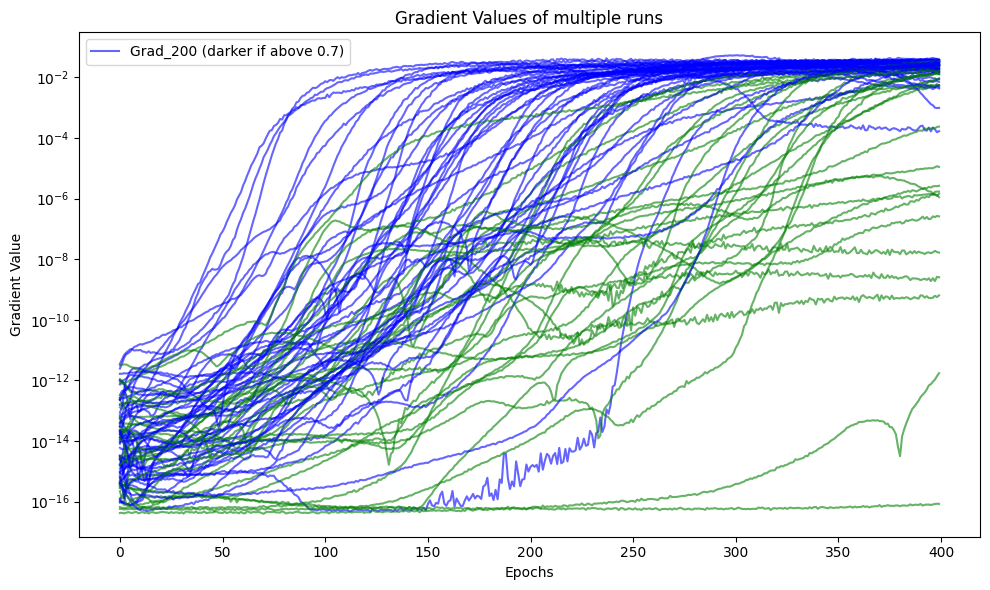

In [12]:
import matplotlib.pyplot as plt

# Define your threshold for "high-accuracy" seeds
THRESHOLD = 0.7

# Specify the Grad_* columns you want to plot
grad_cols = {
    # "Grad_150": {"base_color": "red", "darker_color": "darkred"},
    "Grad_200": {"base_color": "green", "darker_color": "blue"},
    # "Grad_250": {"base_color": "blue", "darker_color": "darkblue"}
}

# Transparency settings
alpha_light = 0.6  # for seeds below threshold
alpha_dark = 0.6   # for seeds above threshold

# Create the figure
plt.figure(figsize=(10, 6))

# Keep track of which gradient columns we've labeled (for the legend)
labeled_cols = set()

for seed, df in combined_dataframes.items():
    # 1) Determine if this seed is "above threshold" in accuracy
    #    If no 'Avg_Accuracy' column, we assume it does not exceed THRESHOLD.
    if 'Avg_Accuracy' in df.columns:
        max_acc = df['Avg_Accuracy'].max()
        above_threshold = max_acc > THRESHOLD
    else:
        above_threshold = False
    
    # 2) For each gradient column of interest, plot in either normal or darker color
    for grad_col, colors in grad_cols.items():
        if grad_col not in df.columns:
            continue  # skip if the column doesn't exist for this seed
        
        # Base color for this Grad_* column
        base_color = colors["base_color"]
        
        # If the seed’s accuracy is above threshold, use a darker color and higher alpha
        if above_threshold:
            color = colors["darker_color"]
            alpha_val = alpha_dark
        else:
            color = base_color
            alpha_val = alpha_light
        
        # Plot once with a label if we haven't labeled this Grad_* yet
        if grad_col not in labeled_cols:
            label = f"{grad_col} (darker if above {THRESHOLD})"
            plt.plot(df.index, df[grad_col], color=color, alpha=alpha_val, label=label)
            labeled_cols.add(grad_col)
        else:
            # Subsequent lines for the same Grad_* column get no label
            plt.plot(df.index, df[grad_col], color=color, alpha=alpha_val)

# Optionally set a log-scale for the y-axis
plt.yscale('log')

plt.xlabel("Epochs")
plt.ylabel("Gradient Value")
plt.title("Gradient Values of multiple runs")
plt.legend()
plt.tight_layout()
plt.show()


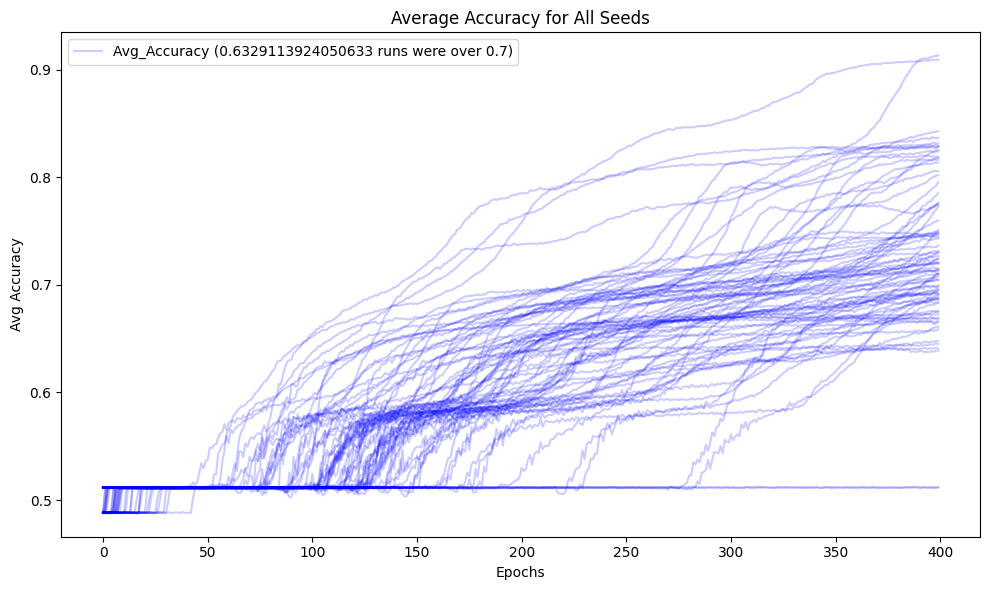

In [13]:
alpha = 0.2
threshold = 0.7
"""
Plot the 'Avg_Accuracy' column for all seeds on a single plot in the same color.
Count how many seeds exceed the given 'threshold' in accuracy, and display that count in the legend.

:param combined_dataframes: Dictionary {seed: DataFrame} with an 'Avg_Accuracy' column.
:param alpha: Transparency level for the lines (0=transparent, 1=opaque).
:param threshold: The accuracy threshold used to count "successful" seeds.
"""

# 1) Count how many seeds exceed the threshold at any point
count_exceeding = 0
for seed, df in combined_dataframes.items():
    if "Avg_Accuracy" in df.columns:
        max_acc = df["Avg_Accuracy"].max()
        if max_acc > threshold:
            count_exceeding += 1

# 2) Plot all seeds' accuracy
plt.figure(figsize=(10, 6))

color = 'blue'
for seed, df in combined_dataframes.items():
    if "Avg_Accuracy" in df.columns:
        plt.plot(df.index, df["Avg_Accuracy"], color=color, alpha=alpha)
    else:
        print(f"Warning: 'Avg_Accuracy' not found in DataFrame for seed {seed}")

# 3) Add a single legend entry showing how many seeds exceeded the threshold
#    We do this by plotting an empty line (so it appears in the legend)
plt.plot([], [], color=color, alpha=alpha,
            label=f"Avg_Accuracy ({count_exceeding / len(combined_dataframes)} runs were over {threshold})")


# 4) Final labeling and show
plt.xlabel("Epochs")
plt.ylabel("Avg Accuracy")
plt.title("Average Accuracy for All Seeds")
plt.legend()
plt.tight_layout()
plt.show()
